# Lesson 6 - Generative Modelling Intro (AutoEncoders)

noise -> data

AEs (https://colab.research.google.com/drive/1Rk8cXMdad9ASIVI6avPyp5bl0qmeOu6S#scrollTo=jLKvlxgB7qXc)

VAEs

In [ ]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Downloading the MNIST dataset we'll use in examples
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been dowloaded.\n')

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MNIST dataset has been dowloaded.



## Auto-Encoders, Learned Representations and VAEs

We've seen that pre-trained networks can learn representations that are useful for classification. And that we can use some of these learned representations to create a measure of structural or stylistic similarity between images, which we can re-purpose for style transfer. 

How does this idea of learning useful representations tie into generating new images? 

In this section we'll meet something called an autoencoder.

![ae](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)

The idea here is to make a neural network with two parts: and encoder and a decoder. The encoder will take an image and process it until, at some point, we reach a 'bottleneck' layer where only a handful of numbers are passed to the next layer. We call this small set of numbers `h` or `z`* or 'the latent representation of the image'. The task of the network during training is to learn how to produce a useful representation so that the decoder can re-create the input image with minimal loss. 

By setting things up in this way, we're forcing the network to learn enough about the data to create a useful representation AND a decoder network that can create nice outputs despite only seeing this very compressed representation of the input image. 

Take a moment to appreciate this: as with many things in deep learning, we don't do anything too special ourselves - we just set an objective and let the network learn how to do things!

*some people are picky about notation, but we'll be fairly flexible and just try to clarify what something is rather than relying too heavily on one poor letter for meaning.

### Creating a Convolutional AutoEncoder

Here we build on the simple networks we made in lesson 3 to create our network. Skim the code and see if you can understand how the encoder and decoder work. Note that `ConvTranspose2d` is effectively the reverse of a convolution layer - check the docs for details.

In [ ]:
class ConvAE(nn.Module):
  def __init__(self, hdim=20):
    super(ConvAE, self).__init__()
    # Encoder layers
    self.enc_conv1 = nn.Conv2d(1, 32, 3)
    self.enc_conv2 = nn.Conv2d(32, 32, 3)
    self.enc_fc1 = nn.Linear(32*24*24, 128)
    self.enc_fc2 = nn.Linear(128, hdim)

    # Decoder layers
    self.dec_fc1 = nn.Linear(hdim, 128)
    self.dec_fc2 = nn.Linear(128, 32*24*24)
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
    self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
    self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

  def encode(self, x):
    x = self.enc_conv1(x)
    x = F.relu(x)
    x = self.enc_conv2(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.enc_fc1(x)
    x = F.relu(x)
    x = self.enc_fc2(x)
    return x

  def decode(self, x):
    x = self.dec_fc1(x)
    x = F.relu(x)
    x = self.dec_fc2(x)
    x = F.relu(x)
    x = self.dec_unflatten(x)
    x = self.dec_conv1(x)
    x = F.relu(x)
    x = self.dec_conv2(x)
    return x

  def forward(self, x):
    return self.decode(self.encode(x))

In [ ]:
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False) # TODO use whole dataset

torch.Size([1, 20])
torch.Size([1, 1, 28, 28])


<matplotlib.image.AxesImage>

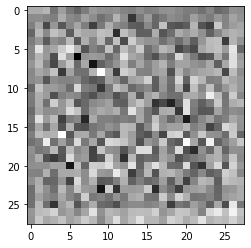

In [ ]:
# Create a network as defined above and pass an image through it
ae = ConvAE()
encoded = ae.encode(mnist[0][0].unsqueeze(0))
print(encoded.shape)
decoded = ae.decode(encoded)
print(decoded.shape)
plt.imshow(decoded.detach().squeeze(), cmap='gray')

Time to train it. I stole most of this code from the NMA content on this topic, which is where I'd suggest you start if you want to go deeper.

In [ ]:
def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in tqdm(range(epochs)):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
    
      break
    break # TODO remove 

train_autoencoder(ae, mnist, device)

  0%|          | 0/20 [00:00<?, ?it/s]

After training, we no longer get the noisy nothingness we saw as the output of the network. Instead, the images look impressively close to the originals! You could try lowering the size of the hidden dimension and seeing how far you can push it.

In [ ]:
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

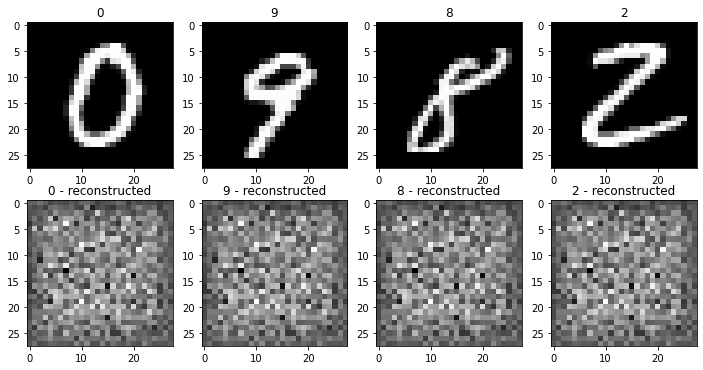

In [ ]:
# Plot the reconstructed versions of some random samples from the validation set
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
  im, label = mnist_val[random.randint(0, len(mnist_val))]
  axs[0][i].imshow(im.squeeze(), cmap='gray')
  axs[0][i].set_title(label)
  axs[1][i].imshow(ae(im.unsqueeze(0).to(device)).squeeze().detach().cpu(), cmap='gray')
  axs[1][i].set_title(str(label) + ' - reconstructed')

Autoencoders are great, and have many uses (data compression, for example). But they aren't so great at producing new images that look like the training data. Ideally, we'd pick a random point in the latent space (i.e. a set of random numbers to be the `h`) and run it through the decoder to get something that looks like a real image. Instead, if we try this we see mostly strange alien shapes:

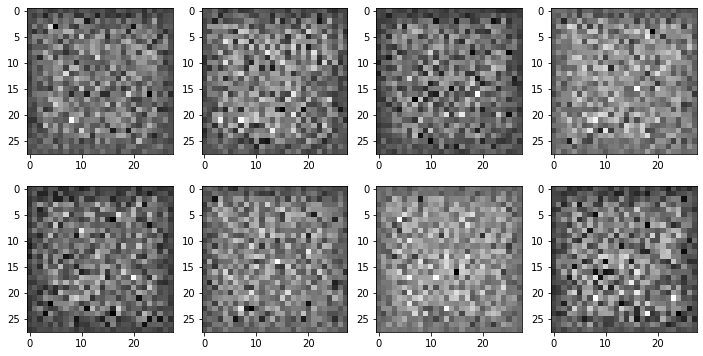

In [ ]:
# Generate new images from random zs
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
  im = ae.decode(torch.randn(1, 20).to(device))
  axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

This is because the autoencoder learns to map different image classes to drastically different parts of the latent space - there is no incentive for it to learn a 'neat' representation, only that it learns one that let's it solve the problem as we framed it. 

To 'fix' this, we need to add an additional component to the loss which stops it from keeping all the latent representations wildly separated. The details are technical and you're brain is probably feeling a little full, so we won't actually try this ;) Just know that once we add this extra magical bit of code, we get something called a VARIATIONAL auto-encoder ('VAE') which enerates new images that look much closer to the training data. 

TODO VAE

For a deeper dive into all of this, check out https://deeplearning.neuromatch.io/tutorials/W2D5_GenerativeModels/student/W2D5_Tutorial1.html

In [ ]:
# TODO consolidate datasets into bonus notebook that provides imports